# Data Augmentation for Computer Vision with PyTorch: Image Classification

Install package requirements.

In [ ]:
!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
!pip install git+https://github.com/aleju/imgaug

Next, import all libraries and configure matplotlib to display larger plots.

In [18]:
import PIL
import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

from torchvision.utils import make_grid
from torchvision import transforms

def show_dataset(dataset, n=6):
    imgs = torch.stack([dataset[i][0] for _ in range(n)
                       for i in range(len(dataset))])
    grid = make_grid(imgs).numpy()
    plt.imshow(np.transpose(grid, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')

Augmenting data with PyTorch is very straightforward. We can use the transforms provided in torchvision: [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html).

To compose several transforms together, we use [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) and pass the transforms as a list. The transforms are applied following the list order.

In [7]:
tfs = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor()
])

We then pass the transforms to [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder) and the images will be automatically augmented.

If you want to define your own [dataset](https://pytorch.org/docs/master/torchvision/datasets.html) class, you just have to call `transforms(samples)` to perform the transforms on your samples. Check the source code for [`ImageFolder`](https://github.com/pytorch/vision/blob/4db0398a2b02aae790013efbc868f2d795eb2ef7/torchvision/datasets/folder.py#L150) for more details.

In [8]:
dataset = torchvision.datasets.ImageFolder('../data/classification/', transform=tfs)

That's all! Let's visualize some of the transformed images:

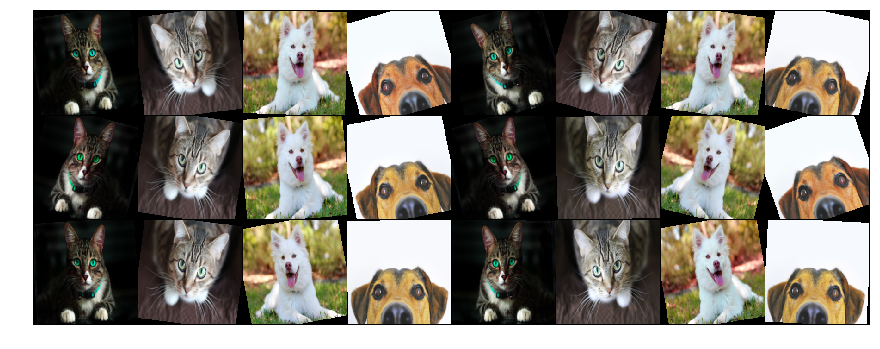

In [9]:
show_dataset(dataset)

Ok, but the augmentations available on PyTorch are very simple. What if we want to perform more interesting augmentations?

Let's use [imgaug](https://github.com/aleju/imgaug) to achieve that.

In [10]:
from imgaug import augmenters as iaa
import imgaug as ia

We can perform more complex augmentation and define more complex behaviors with imgaug.

Besides having more image transformation techniques, imgaug also has interesting behaviors such as [`Sometimes`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sometimes), [`SomeOf`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#someof) and [`OneOf`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#oneof).

Note that for imgaug, we should convert the PIL images to NumPy arrays before applying the transforms.

You should always be careful with the `dtype` and dimension ordering when applying data augmentation and training neural networks. It's a good practice to visualize the augmented images and print some of the input values before training a neural network.

In [11]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

tfs = transforms.Compose([
    ImgAugTransform(),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder('../data/classification/', transform=tfs)

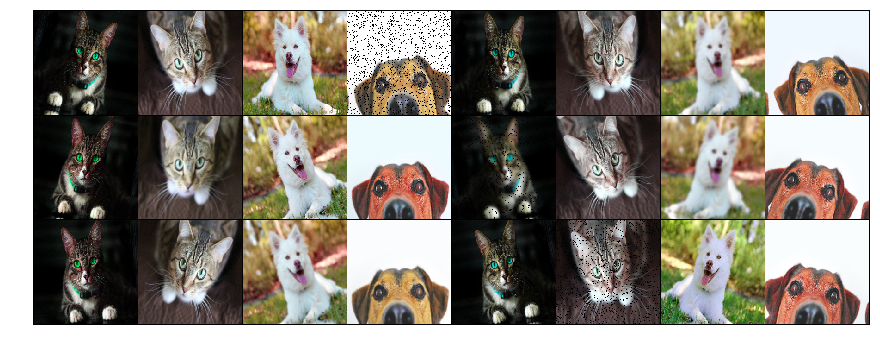

In [12]:
show_dataset(dataset)

imgaug also accepts a list of images instead of a single image. To augment them, use `aug.augment_images`. This may be useful if you are implementing a custom dataset that will load several images at once, before augmenting them. 

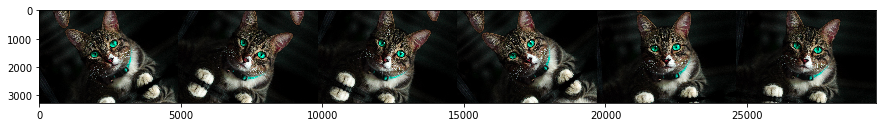

In [26]:
dataset = torchvision.datasets.ImageFolder('../data/classification/')

aug = iaa.Affine(rotate=(-45, 45), mode='symmetric')
imgs = [np.array(dataset[0][0]) for _ in range(6)]
imgs = aug.augment_images(imgs)
plt.imshow(np.hstack(imgs))

If you want to create your own image transformations, you just have to write a Python function that will transform the given image (or images) and use it with [`transforms.Lambda`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Lambda), [`iaa.Lambda`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#lambda), or to call it directly in a custom transform class.

# Time

Let's perform a simple benchmark to compare the running time for imgaug and for PyTorch. We can see that the results are very similar for the same augmentation techniques.

In [30]:
import time

transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20)
])

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.AddToHueAndSaturation(value=(-20, 20), per_channel=True),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='constant'),
        ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

transforms_imgaug = ImgAugTransform()

datasets = {
'pytorch': torchvision.datasets.ImageFolder('../data/classification/', transform=transforms_pytorch),
'imgaug' : torchvision.datasets.ImageFolder('../data/classification/', transform=transforms_imgaug)
}

times = {'pytorch': [], 'imgaug': []}
for _ in range(20):
    for mode in ('pytorch', 'imgaug'):
        start = time.time()
        img_pytorch = np.vstack((np.hstack((np.asarray(datasets[mode][i][0]) for _ in range(6))) for i in range(4)))
        end = time.time()
        times[mode].append(end - start)
    
for mode in ('pytorch', 'imgaug'):
    t = np.array(times[mode])
    print("{}: {:.04f}".format(mode, t.min()))

pytorch: 14.9922
imgaug: 16.7562
